In [31]:
import pickle as pkl    
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import numpy as np
import tqdm
import concurrent.futures
import torch
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### load pseudo labels


In [93]:
def process_file(file):
    epoch = file.split("_")[2].split(".")[0][1:]
    with open(os.path.join(pseudo_labels_folder_path, file), "rb") as f:
        pseudo_labels_dict = pkl.load(f)

    frame_dfs = []
    for key, value in pseudo_labels_dict.items():
        pred_scores = value['gt_boxes'][:,-1]
        labels = value['gt_boxes'][:,-2]
        gt_boxes = value['gt_boxes'][:,:-2]

        frame_df = pd.DataFrame({"pred_scores": pred_scores, "label": labels, "gt_boxes": list(gt_boxes)})
        frame_df["frame_id"] = key
        frame_df["epoch"] = epoch
        frame_dfs.append(frame_df)

    return pd.concat(frame_dfs)

def load_pseudo_labels(pseudo_labels_folder_path):
    # Function to process each file


    # Use concurrent futures to process files in parallel
    files = [file for file in os.listdir(pseudo_labels_folder_path) if file.endswith(".pkl")]
    #with concurrent.futures.ProcessPoolExecutor() as executor:
    #    results = list(executor.map(process_file, files))
    results = []
    for file in tqdm.tqdm(files):
        results.append(process_file(file))
        

    # Concatenate all results
    pseudo_labels = pd.concat(results)

    ps_namemap = {
        -1: "Unsure",
        1: "Vehicle",
        2: "Other",
        3: "Other",
        4: "Other",
    }



    # Map labels to names
    pseudo_labels["label"] = pseudo_labels["label"].astype(int).map(ps_namemap)

    pseudo_labels.reset_index(drop=True, inplace=True)

    return pseudo_labels


#pseudo_labels_folder_path = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_STrooftop/D1_3epochs_STrooftop_ft_D6_50epochs_ros_vehicles/ps_label"

#pseudo_labels = load_pseudo_labels(pseudo_labels_folder_path)

def get_gt_labels(tar_dataset):
    dataset_names = ["AVLTruck", "AVLRooftop", "ZOD"]

    #annotation paths
    annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_train.pkl"
    annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_train.pkl"
    annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_train_full.pkl"

    #load the annotations and make a dataframe
    with open(annotation_path_avltruck, 'rb') as f:
        annotations_avltruck = pkl.load(f)
    with open(annotation_path_avlrooftop, 'rb') as f:
        annotations_avlrooftop = pkl.load(f)
    with open(annotation_path_zod, 'rb') as f:
        annotations_zod = pkl.load(f)

    avltruck_content = []
    for i in range(len(annotations_avltruck)):
        content = {}
        content["names"] = annotations_avltruck[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[0]
        content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
        avltruck_content.append(content)

    avlrooftop_content = []
    for i in range(len(annotations_avlrooftop)):
        content = {}
        content["names"] = annotations_avlrooftop[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[1]
        content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
        avlrooftop_content.append(content)

    zod_content = []
    for i in range(len(annotations_zod)):
        content = {}
        content["names"] = annotations_zod[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[2]
        content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
        zod_content.append(content)

    #make a dataframe
    df_avltruck_annos = pd.DataFrame(avltruck_content)
    df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
    df_zod_annos = pd.DataFrame(zod_content)

    #make a dataframe with all results
    df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
    df_annos_full = df_annos_full.reset_index(drop=True)

    #explode the lists
    cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
    df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
    df_annos_full = pd.concat(df_annos_lists, axis=1)

    prev_len = len(df_annos_full)
    df_annos_full.dropna(inplace=True)
    print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")


    namemap_avltruck = {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Truck": "Truck",
        "Trailer": "Truck",
        "Dont_Care": "DontCare",
        "Other": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_avlrooftop =  {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "LargeVehicle_Truck": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_Bus_Bendy": "Truck",
        "Trailer": "Truck",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "PPObject": "DontCare",
        "PPObject_Stroller": "DontCare",
        "Dont_care": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_zod = {
        "Vehicle_Car": "Vehicle",
        "Vehicle_Van": "Vehicle",
        "Vehicle_Truck": "Truck",
        "Vehicle_Trailer": "Truck",
        "Vehicle_Bus": "Truck",
        "Vehicle_HeavyEquip": "Truck",
        "Vehicle_TramTrain": "Truck",
        "VulnerableVehicle_Motorcycle": "Cyclist",
        "VulnerableVehicle_Bicycle": "Cyclist",
        "Pedestrian": "Pedestrian",
        #'Placeholder': 'DontCare',
    }

    #apply name maps for all data of each dataset
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

    #drop all dont cares
    df_annos_full = df_annos_full[df_annos_full['names'] != 'DontCare']

    gt_labels = df_annos_full[df_annos_full['dataset'] == tar_dataset]
    gt_labels.reset_index(drop=True, inplace=True)

    return gt_labels


def calc_ious(pseudo_labels, gt_labels):
    #add iou score to the dataframe, default is 0
    pseudo_labels['iou'] = 0
    pseudo_labels['true_label'] = "Background"
    gt_labels['iou'] = 0
    gt_labels['det_label'] = "Background"

    #det detection frame ids
    ps_frame_ids = pseudo_labels['frame_id'].unique()

    # Loop over all frames
    for ps_frame_id in tqdm.tqdm(ps_frame_ids):

        gt_labels_frame= gt_labels[gt_labels['frame_id'] == ps_frame_id]
        pseudo_labels_frame = pseudo_labels[pseudo_labels['frame_id'] == ps_frame_id]

        if len(gt_labels_frame) == 0 or len(pseudo_labels_frame) == 0:
            continue

        # Convert the boxes to numpy
        gt_boxes_frame = np.stack(gt_labels_frame["gt_boxes_lidar"].values)
        ps_boxes_frame = np.stack(pseudo_labels_frame["gt_boxes"].values)

        #iou_matrix = iou3d_nms_utils.boxes_iou3d_gpu(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes_frame, ps_boxes_frame)
        # Get the max iou for each det box
        max_ious_ps = np.max(iou_matrix, axis=0)
        max_ious_ps_idx = np.argmax(iou_matrix, axis=0)

        #get class for each detection
        cls_dets = gt_labels_frame['label'].values[max_ious_ps_idx]
        
        # Update the iou score for each detection in the original DataFrame
        pseudo_labels.loc[pseudo_labels_frame.index, 'iou'] = max_ious_ps
        pseudo_labels.loc[pseudo_labels_frame.index, 'true_label'] = cls_dets

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)
        # Update the iou score for each gt in the original DataFrame
        gt_labels.loc[gt_labels_frame.index, 'iou'] = max_ious_gts
        

    iou_thresholds = [0.1, 0.3, 0.5, 0.7]

    #for each detection, add detected_0.3, detected_0.5, detected_0.7
    for iou_threshold in iou_thresholds:
        pseudo_labels[f'detected_{iou_threshold}'] = pseudo_labels['iou'] >= iou_threshold
        gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold

    return pseudo_labels, gt_labels

    
def remove_non_fov(pseudo_labels, gt_labels, do_print=False):
    #Calculate fov where detections are avaliable (for ZOD)
    x_coors_dets = gt_labels['gt_boxes_lidar'].apply(lambda x: x[0])
    y_coors_dets = gt_labels['gt_boxes_lidar'].apply(lambda x: x[1])
    gt_labels['azimuth'] = np.arctan2(y_coors_dets, x_coors_dets)

    max_angle = np.max(gt_labels['azimuth'])
    min_angle = np.min(gt_labels['azimuth'])

    # use 60° fov for avltruck and avlrooftop
    max_angle = 60*2*np.pi/360
    min_angle = -60*2*np.pi/360

    if do_print: print(f"Max angle in gts: {max_angle}")
    if do_print: print(f"Min angle in gts: {min_angle}")


    #mask detections that are not in fov
    x_coors_dets = pseudo_labels['gt_boxes'].apply(lambda x: x[0])
    y_coors_dets = pseudo_labels['gt_boxes'].apply(lambda x: x[1])
    pseudo_labels['azimuth'] = np.arctan2(y_coors_dets, x_coors_dets)

    num_labels_pre_fov = len(pseudo_labels)
    pseudo_labels = pseudo_labels[(pseudo_labels['azimuth'] <= max_angle) & (pseudo_labels['azimuth'] >= min_angle)]
    if do_print: print("Number of removed detections outside fov", num_labels_pre_fov - len(pseudo_labels))

    #mask gts that are not in fov
    x_coors_dets = gt_labels['gt_boxes_lidar'].apply(lambda x: x[0])
    y_coors_dets = gt_labels['gt_boxes_lidar'].apply(lambda x: x[1])
    gt_labels['azimuth'] = np.arctan2(y_coors_dets, x_coors_dets)

    num_labels_pre_fov = len(gt_labels)
    gt_labels = gt_labels[(gt_labels['azimuth'] <= max_angle) & (gt_labels['azimuth'] >= min_angle)]
    if do_print: print("Number of removed gts outside fov", num_labels_pre_fov - len(gt_labels))

    return pseudo_labels, gt_labels

def plot_confusion_matrix(pseudo_labels, gt_labels, epochs, iou_threshold, pseudo_labels_folder_path=None, show_plot=True, do_print=False):
    if do_print:
        #print number of detections
        print(f"Number of detections: {len(pseudo_labels)}")
        #num dets per frame
        print(f"Number of detections per frame: {round(len(pseudo_labels)/len(pseudo_labels['frame_id'].unique()),2)}")

        #num gt
        print(f"Number of gt: {len(gt_labels)}")
        #num gt per frame
        print(f"Number of gt per frame: {round(len(gt_labels)/len(gt_labels['frame_id'].unique()),2)}")

        print()

    iou_threshold = 0.5

    #detected as _ true label
    pseudo_labels_vehicles = pseudo_labels[pseudo_labels['label'] == 'Vehicle']
    vehicles_vehicle = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Vehicle')])
    vehicles_other = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Other')])
    vehicles_background = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_other = pseudo_labels[pseudo_labels['label'] == 'Other']
    other_vehicle = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Vehicle')])
    other_other = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Other')])
    other_background = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_unsure = pseudo_labels[pseudo_labels['label'] == 'Unsure']
    unsure_vehicle = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Vehicle')]) 
    unsure_other = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Other')])
    unsure_background = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == False)])

    background_vehicle = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['label'] == 'Vehicle')])
    background_other = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['label'] == 'Other')])

    if do_print:
        print("Detected as vehicle, true label vehicle: ", vehicles_vehicle)
        print("Detected as vehicle, true label other: ", vehicles_other)
        print("Detected as vehicle, true label background: ", vehicles_background)
        print()
        print("Detected as other, true label vehicle: ", other_vehicle)
        print("Detected as other, true label other: ", other_other)
        print("Detected as other, true label background: ", other_background)
        print()
        print("Detected as unsure, true label vehicle: ", unsure_vehicle)
        print("Detected as unsure, true label other: ", unsure_other)
        print("Detected as unsure, true label background: ", unsure_background)

#    confusion_matrix = [[0, vehicles_background, other_background, unsure_background],
#                        [background_vehicle, vehicles_vehicle, other_vehicle, unsure_vehicle],
#                        [background_other, vehicles_other, other_other, unsure_other],
#                        [0, 0, 0, 0]]
    
    confusion_matrix = [[0, vehicles_background, unsure_background],
                        [background_vehicle, vehicles_vehicle, unsure_vehicle],
                        [0, 0, 0]]
    confusion_matrix = np.array(confusion_matrix)

    plt.figure(figsize=(10, 5))
    plt.title('Confusion matrix epoch'+str(epochs)+' iou'+str(iou_threshold))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.xticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.yticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.yticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.ylabel('True label')
    plt.xlabel('Pseudo label')

    if pseudo_labels_folder_path is not None:
        #save image to path pseudo_labels_folder_path
        plt.savefig(os.path.join(pseudo_labels_folder_path, f"confusion_matrix_e{epochs}_iou{iou_threshold}.png"), dpi=300)

    if show_plot:
        plt.show()

def plot_condidence_histogram(pseudo_labels, gt_labels, epochs, iou_threshold, pseudo_labels_folder_path=None, show_plot=True, do_print=False):
    #plot confidence histogram for each class in one single plot
    for cls in pseudo_labels['label'].unique():
        pseudo_labels_cls = pseudo_labels[pseudo_labels['label'] == cls]
        plt.figure(figsize=(10, 5))
        plt.title('Confidence histogram epoch'+str(epochs)+' iou'+str(iou_threshold)+' class: '+cls)
        sns.histplot(data=pseudo_labels_cls, x="pred_scores", hue="true_label", bins=100, stat="probability", common_norm=False, element="step", fill=False)
        plt.xlabel('Confidence')
        plt.ylabel('Probability')
        #insert legend
        # Manually add the legend
        colors = ['blue', 'orange', 'green']
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
        plt.legend(handles, pseudo_labels_cls["true_label"].unique())

        if pseudo_labels_folder_path is not None:
            #save image to path pseudo_labels_folder_path
            plt.savefig(os.path.join(pseudo_labels_folder_path, f"confidence_histogram_e{epochs}_iou{iou_threshold}_class_{cls}.png"), dpi=300)
        if show_plot:
            plt.show()






### Load gt labels

In [4]:
tar_dataset = "AVLRooftop"
gt_labels = get_gt_labels(tar_dataset)

gt_labels_name_map = {
    "Vehicle": "Vehicle",
    "Pedestrian": "Other",
    "Cyclist": "Other",
    "Truck": "Other",
}

gt_labels["label"] = gt_labels["names"].map(gt_labels_name_map)

Dropped 2796 rows with NaNs


### Load pseudo labels

In [86]:

pseudo_labels_folder_path = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_STrooftop/D1_5epochs_STrooftop_ft_D6_50epochs_ros_05_02_thresh_high_lr001/ps_label/"
pseudo_labels_all = load_pseudo_labels(pseudo_labels_folder_path)


100%|██████████| 3/3 [00:19<00:00,  6.36s/it]


### Do IOU calculations

100%|██████████| 5827/5827 [01:12<00:00, 80.35it/s]


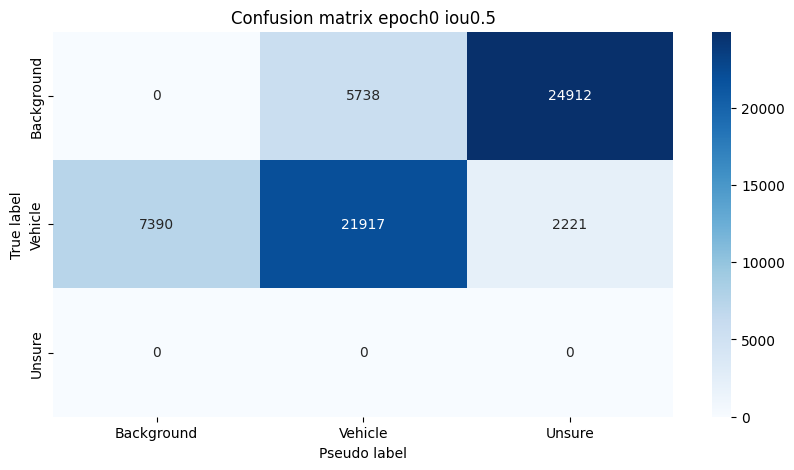

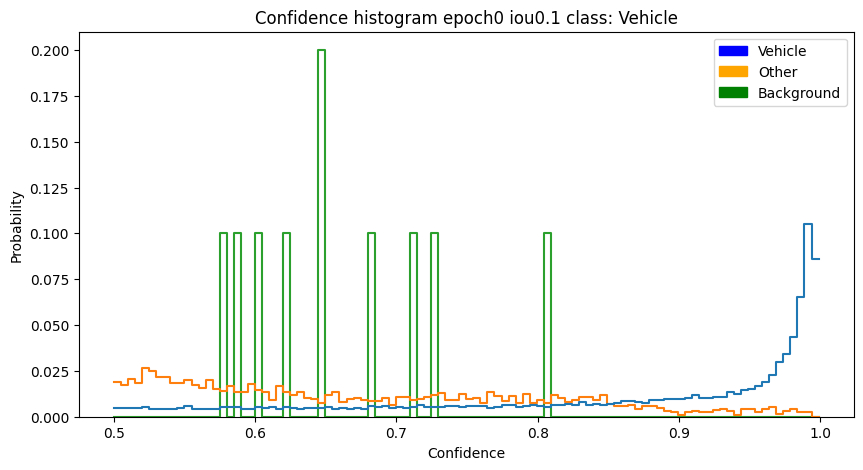

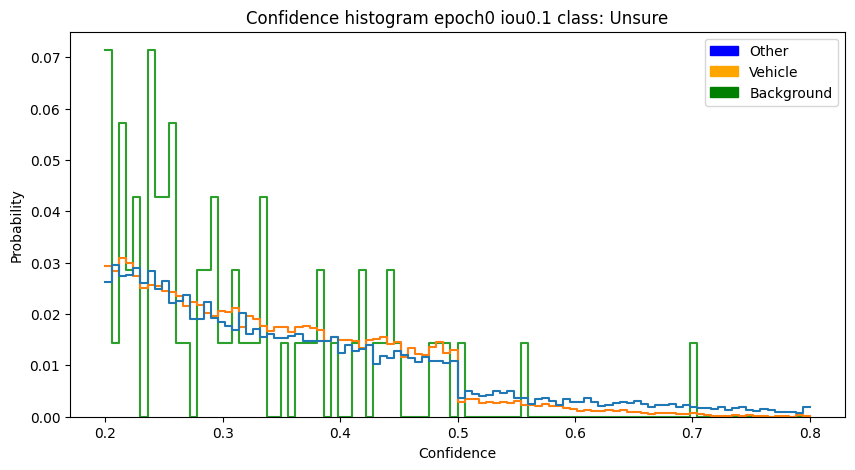

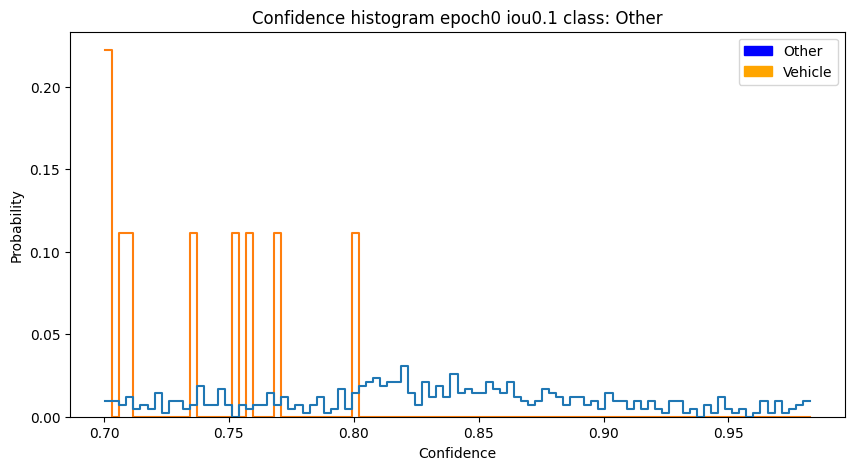

100%|██████████| 5827/5827 [00:58<00:00, 99.51it/s] 


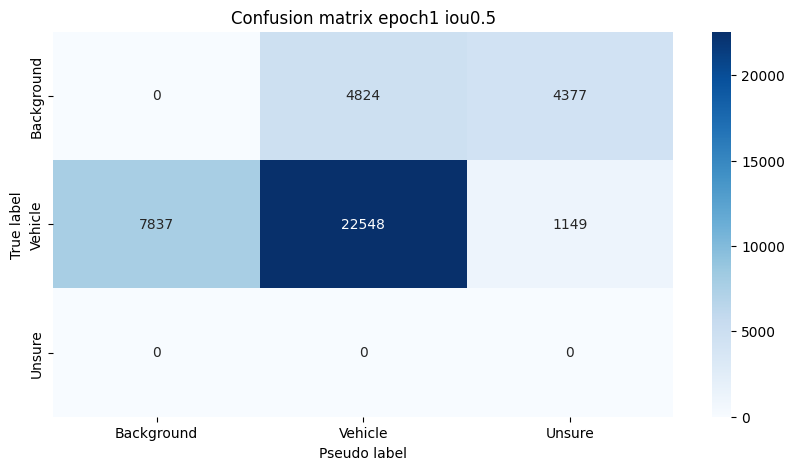

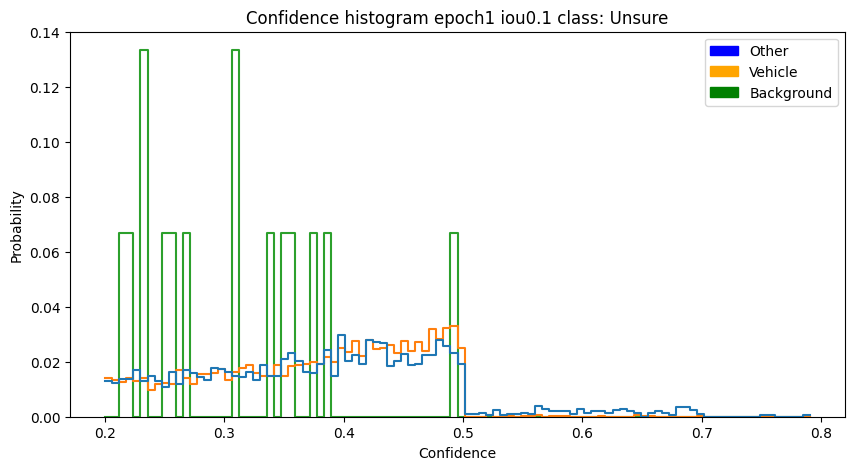

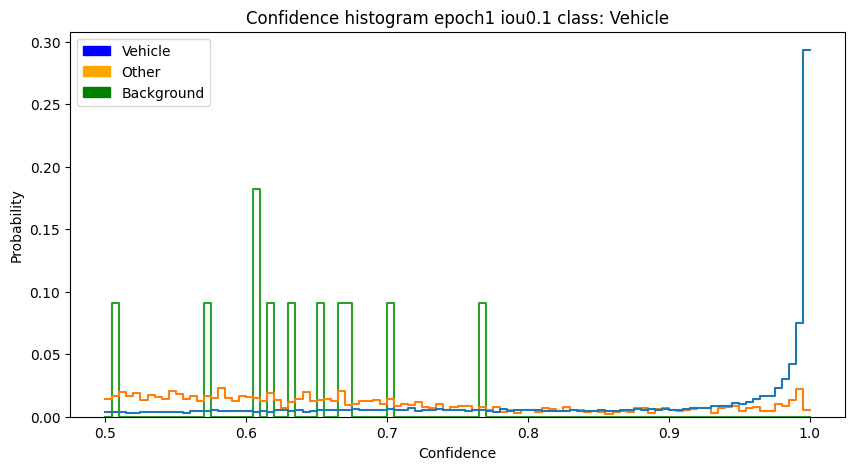

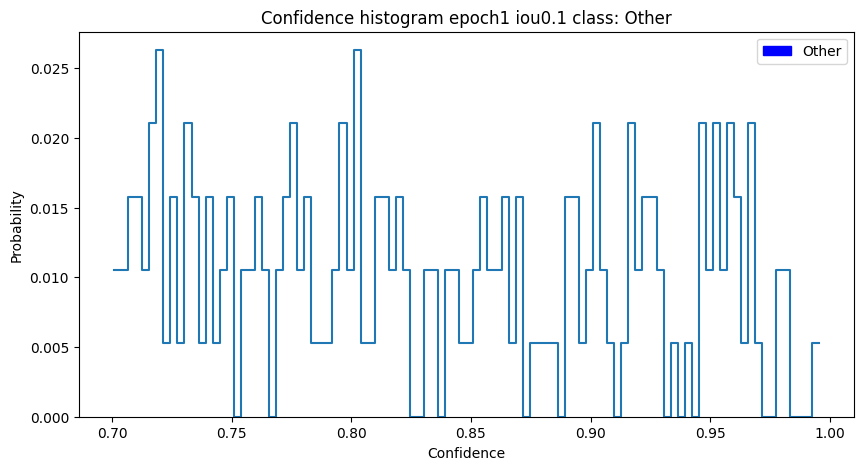

100%|██████████| 5827/5827 [00:55<00:00, 104.20it/s]


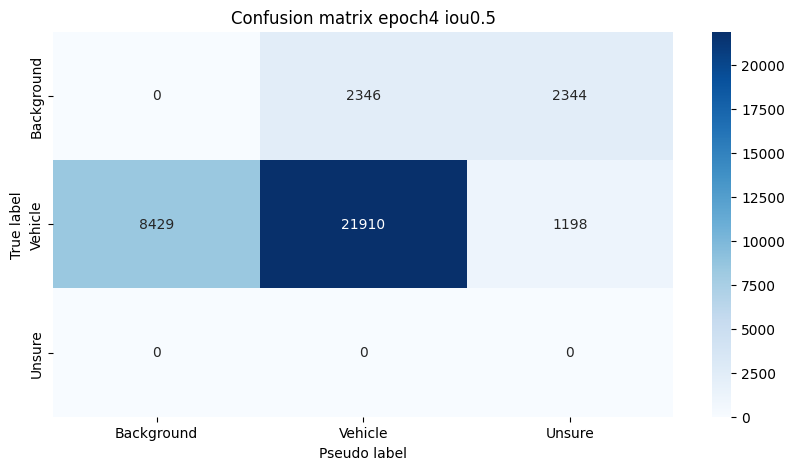

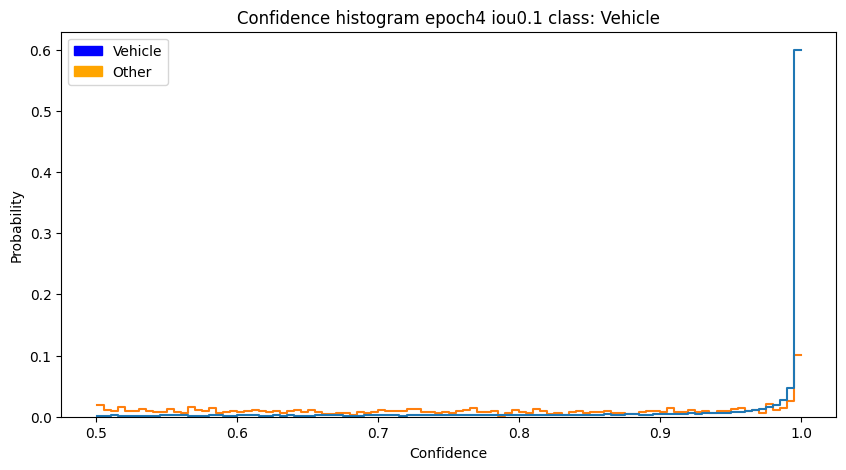

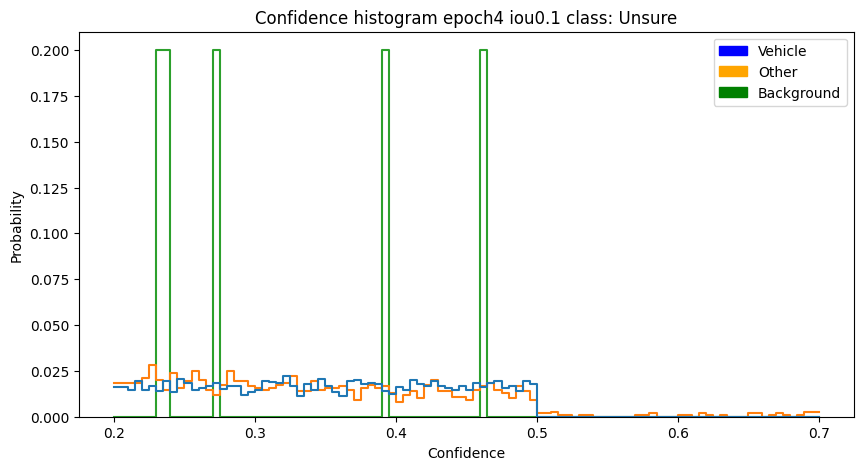

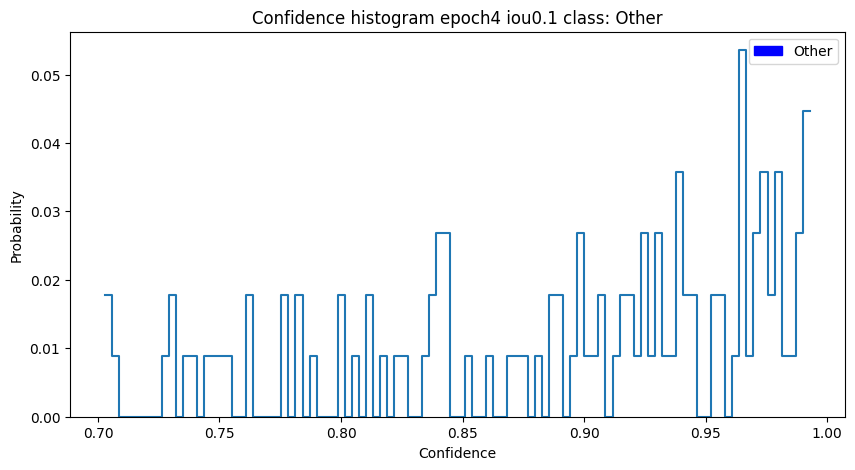

In [94]:
#epochs = [0, 4, 8, 12, 16, 20, 24, 28]
#get epochs from labels_all
epochs = pseudo_labels_all['epoch'].unique()
epochs = [int(epoch) for epoch in epochs]
epochs.sort()

pseudo_labels_all_res = []
gt_labels_all_res = []
#reduce pseudolabels to epoch
for epoch in epochs:
    pseudo_labels = pseudo_labels_all[pseudo_labels_all['epoch'] == str(epoch)]
    
    #calc ious
    pseudo_labels, gt_labels = calc_ious(pseudo_labels, gt_labels)
    pseudo_labels_all_res.append(pseudo_labels)
    gt_labels_all_res.append(gt_labels)
    
    pseudo_labels, gt_labels = remove_non_fov(pseudo_labels, gt_labels, do_print=False)
    #plot confusion matrix
    plot_confusion_matrix(pseudo_labels, gt_labels, epoch, 0.1, pseudo_labels_folder_path, show_plot=True, do_print=False)

    #plot condidence histogram
    plot_condidence_histogram(pseudo_labels, gt_labels, epoch, 0.1, pseudo_labels_folder_path, show_plot=True, do_print=False)


### Plot results

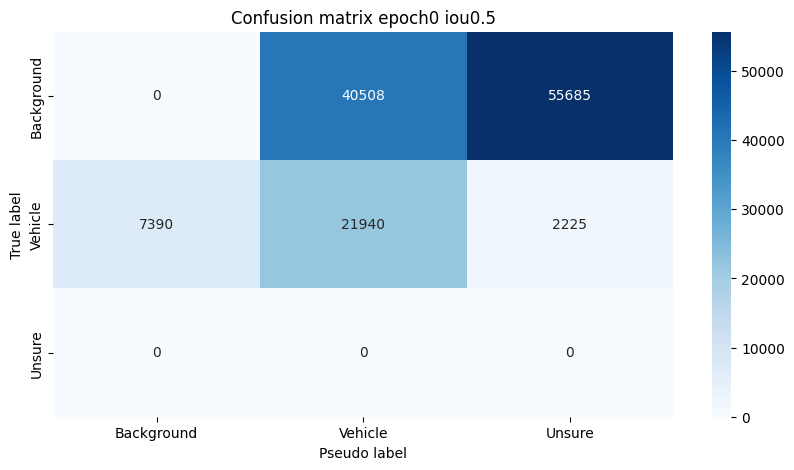

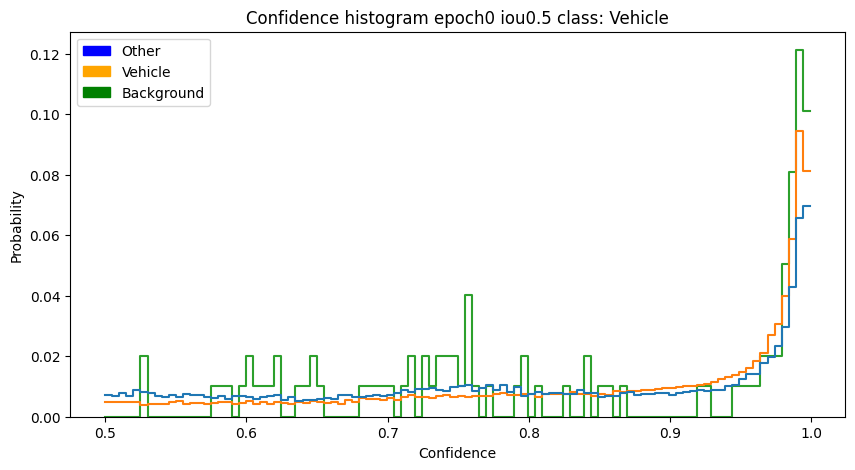

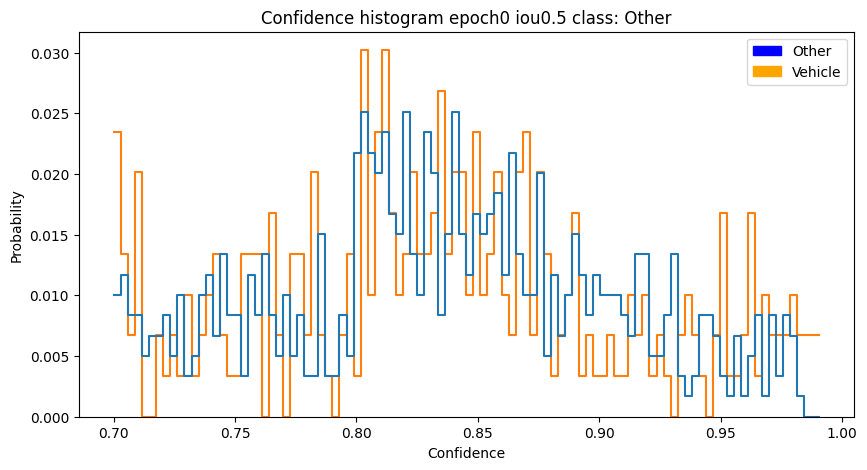

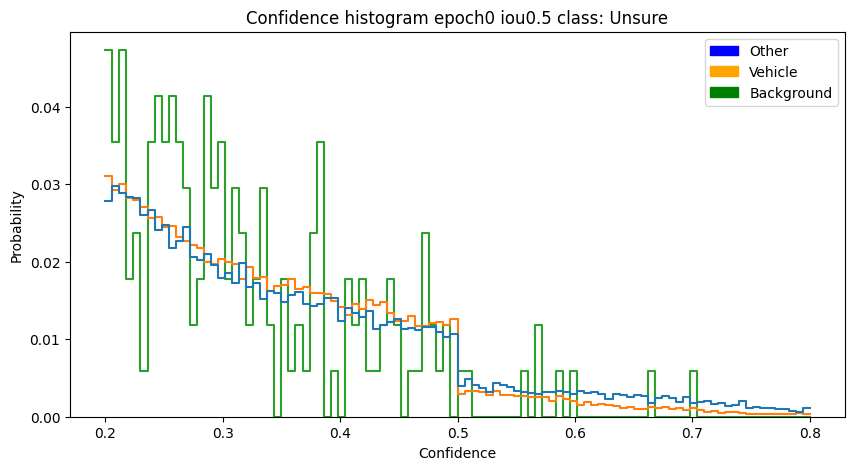

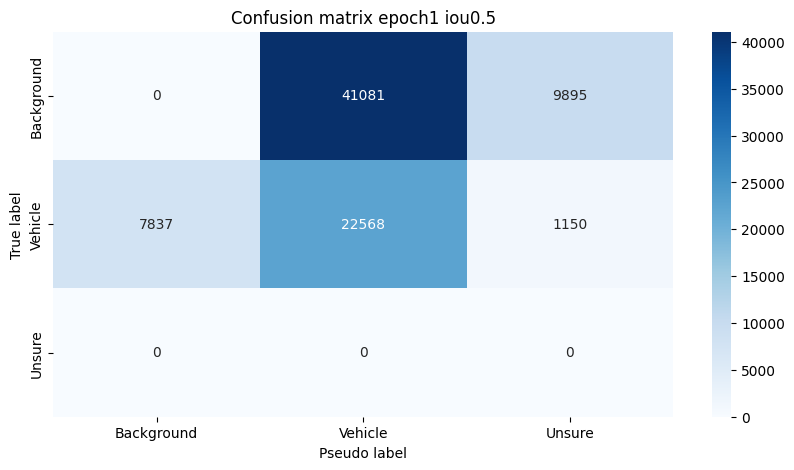

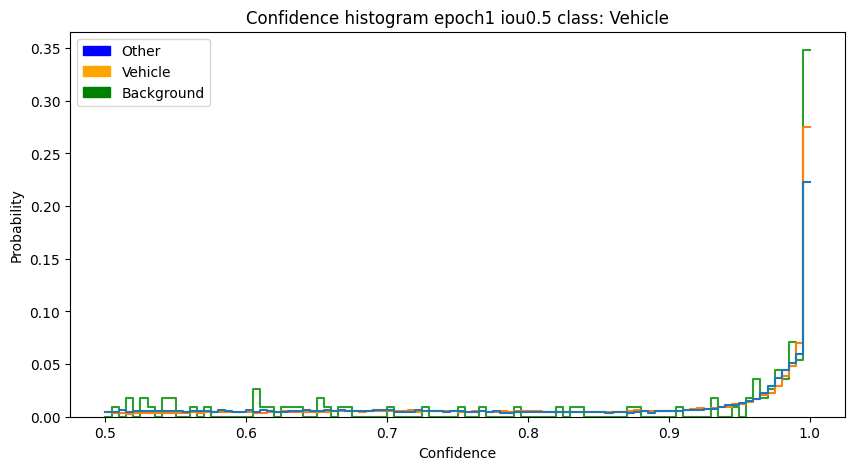

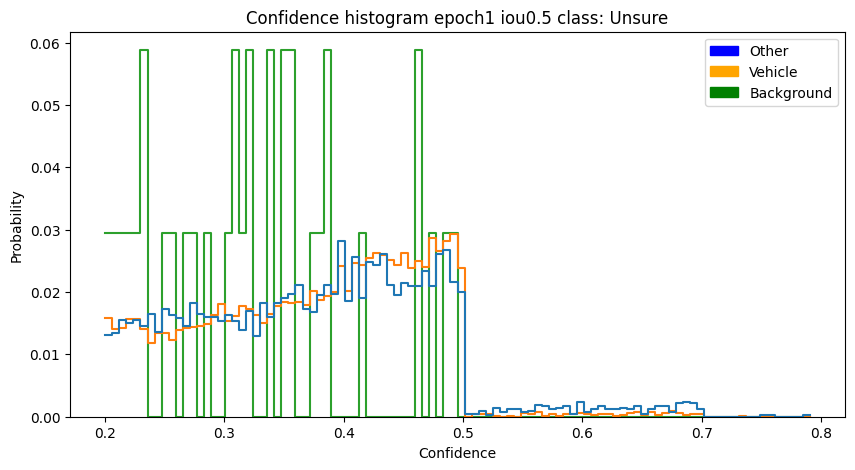

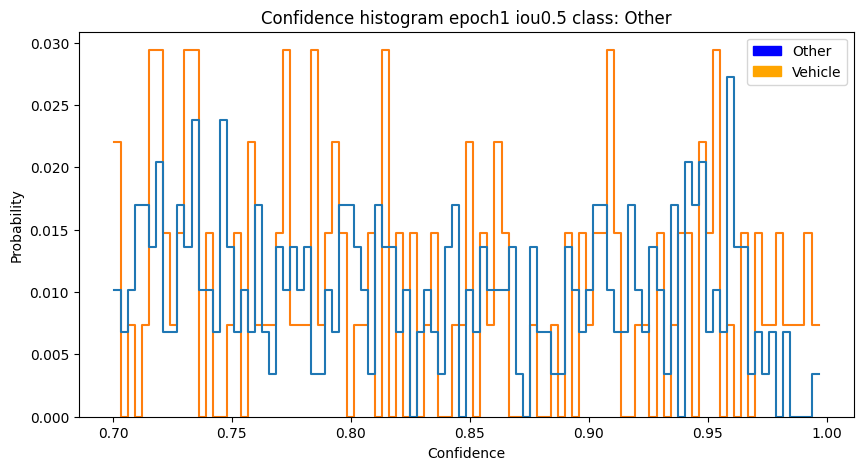

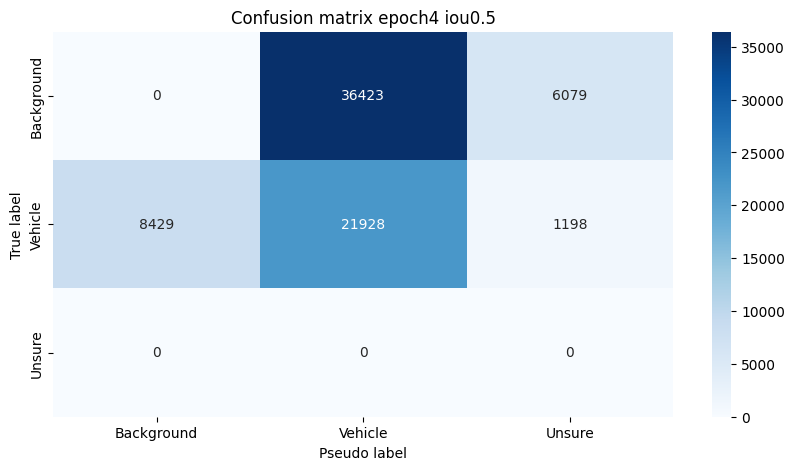

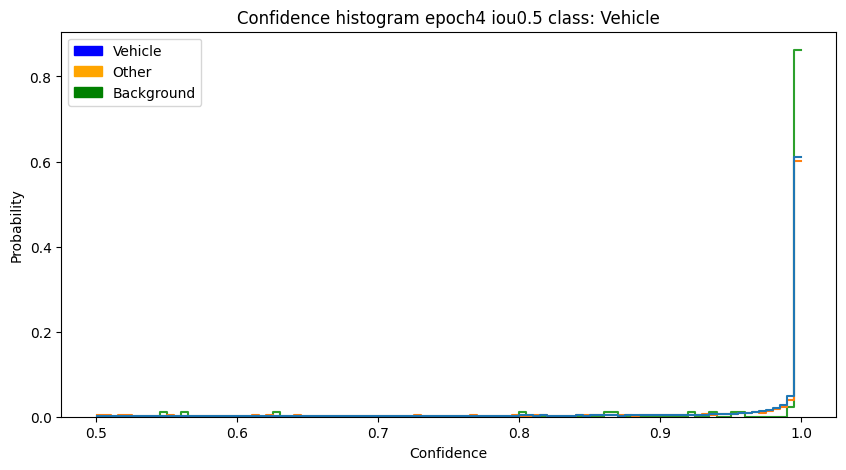

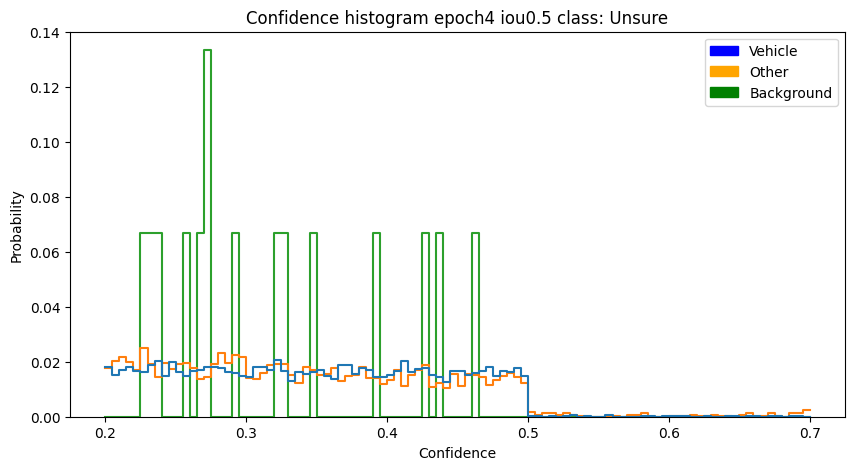

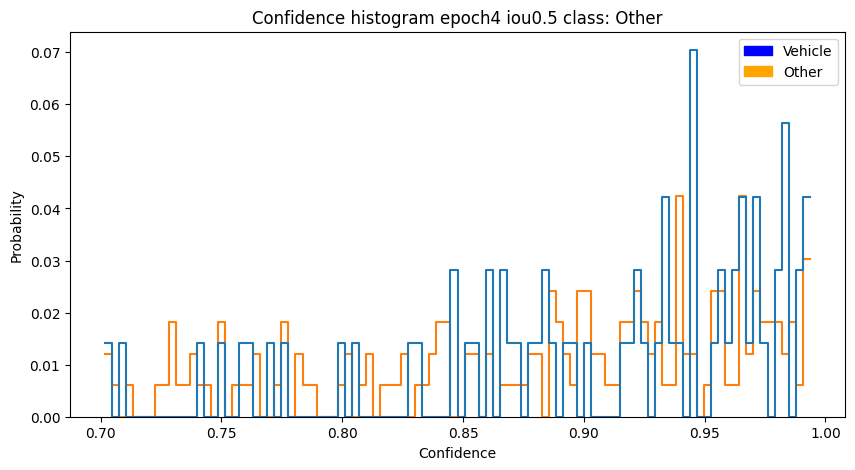

In [89]:
for i, epoch in enumerate(epochs):
    pseudo_labels = pseudo_labels_all_res[i]
    gt_labels = gt_labels_all_res[i]
    #plot confusion matrix
    plot_confusion_matrix(pseudo_labels, gt_labels, epoch, 0.5, pseudo_labels_folder_path, show_plot=True, do_print=False)
    plot_condidence_histogram(pseudo_labels, gt_labels, epoch, 0.5, pseudo_labels_folder_path, show_plot=True, do_print=False)

### Prototyping of plots

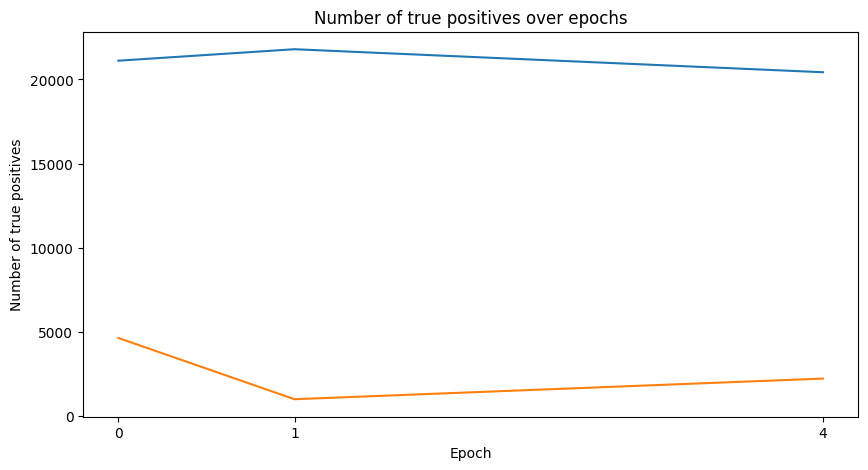

In [76]:
#plot number of true positive vehicles in pseudo_labels_all_res over all epochs
num_true_positives = []
num_car_unsure = []
epochs = pseudo_labels_all['epoch'].unique()
epochs = [int(epoch) for epoch in epochs]
epochs.sort()
for pseudo_labels in pseudo_labels_all_res:
    num_true_positives.append(len(pseudo_labels[(pseudo_labels['iou'] >= 0.5) & (pseudo_labels['label'] == 'Vehicle')]))
    num_car_unsure.append(len(pseudo_labels[(pseudo_labels['iou'] >= 0.5) & (pseudo_labels['label'] == 'Unsure')]))
    

plt.figure(figsize=(10, 5))
plt.title('Number of true positives over epochs')
plt.plot(epochs, num_true_positives, label='True positives')
plt.plot(epochs, num_car_unsure, label='Unsure')
plt.xlabel('Epoch')
plt.ylabel('Number of true positives')
plt.xticks(epochs)
plt.savefig(os.path.join(pseudo_labels_folder_path, f"true_positives_over_epochs.png"), dpi=300)
plt.show()

### Angular distribution

Number of detections: 18285
Number of detections per frame: 3.64
Number of gt: 31555
Number of gt per frame: 5.79


/tmp/ipykernel_307373/2409990705.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_labels_vehicles['azimuth'] = np.arctan2(y_coors_dets, x_coors_dets)
/tmp/ipykernel_307373/2409990705.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels_vehicles['azimuth'] = np.arctan2(y_coors_gt, x_coors_gt)


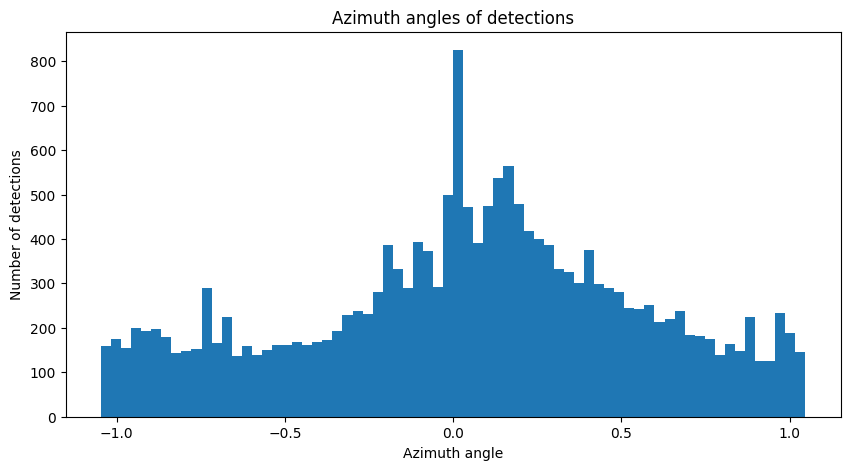

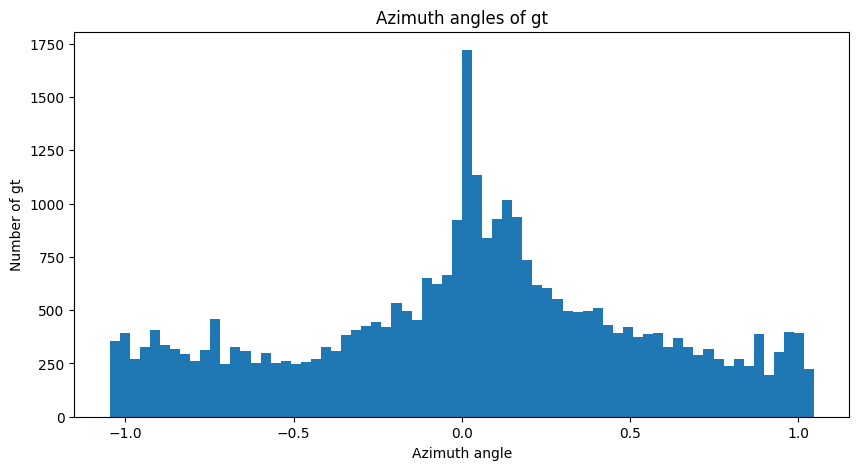

In [ ]:
#make df that only containd vehicles
pseudo_labels_vehicles = pseudo_labels[pseudo_labels['label'] == 'Vehicle']
gt_labels_vehicles = gt_labels[gt_labels['names'] == 'Vehicle']

#print number of detections
print(f"Number of detections: {len(pseudo_labels_vehicles)}")
#num dets per frame
print(f"Number of detections per frame: {round(len(pseudo_labels_vehicles)/len(pseudo_labels_vehicles['frame_id'].unique()),2)}")

#num gt
print(f"Number of gt: {len(gt_labels_vehicles)}")
#num gt per frame
print(f"Number of gt per frame: {round(len(gt_labels_vehicles)/len(gt_labels_vehicles['frame_id'].unique()),2)}")

#plot azimith angles of gt boxes
x_coors_dets = pseudo_labels_vehicles['gt_boxes'].apply(lambda x: x[0])
y_coors_dets = pseudo_labels_vehicles['gt_boxes'].apply(lambda x: x[1])
#calc azimuth angle
pseudo_labels_vehicles['azimuth'] = np.arctan2(y_coors_dets, x_coors_dets)

#calc gt azimuth angle
x_coors_gt = gt_labels_vehicles['gt_boxes_lidar'].apply(lambda x: x[0])
y_coors_gt = gt_labels_vehicles['gt_boxes_lidar'].apply(lambda x: x[1])
#calc azimuth angle
gt_labels_vehicles['azimuth'] = np.arctan2(y_coors_gt, x_coors_gt)

#plot azimuth angles of dets
plt.figure(figsize=(10, 5))
plt.title('Azimuth angles of detections')
plt.xlabel('Azimuth angle')
plt.ylabel('Number of detections')
plt.hist(pseudo_labels_vehicles['azimuth'], bins=70)
plt.show()

#plot azimuth angles of gt
plt.figure(figsize=(10, 5))
plt.title('Azimuth angles of gt')
plt.xlabel('Azimuth angle')
plt.ylabel('Number of gt')
plt.hist(gt_labels_vehicles['azimuth'], bins=70)
plt.show()



